In [1]:
import os
import numpy as np
import pandas as pd

from scipy.io import wavfile
import scipy.fftpack as fftpack
import scipy.signal.windows as windows

import pickle
import time

In [2]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [4]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,scipy,sklearn,time,os

CPython 3.6.3
IPython 6.1.0

numpy 1.12.1
pandas 0.22.0
scipy 1.0.0
sklearn 0.19.1
time n
os n

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 8
interpreter: 64bit


In [5]:
DATASET_PATH = '.\data_v_7_stc'
FS = 16000
LOAD_DATA = True

In [6]:
TRAIN_DIR = os.path.join(DATASET_PATH, 'audio')
train_file = [f for f in os.listdir(TRAIN_DIR) if os.path.isfile(os.path.join(TRAIN_DIR, f))]
train_wave = [w for w in train_file if w[-4:] == '.wav']

In [7]:
df = pd.read_csv(os.path.join(DATASET_PATH, 'meta/meta.txt'), sep='\t', names=['File', '_', '__', 'Duration', 'Class'])
df.drop(['_', '__'], axis=1, inplace=True)

In [8]:
TEST_DIR = os.path.join(DATASET_PATH, 'test')
test_file = [f for f in os.listdir(TEST_DIR) if os.path.isfile(os.path.join(TEST_DIR, f))]
test_wave = [w for w in test_file if w[-4:] == '.wav']

test_tag_split = [(f.split('_'))[:-1] for f in test_wave]
test_tag_list = [ [tag for tag in tag_split if tag != 't'] for tag_split in test_tag_split]
test_tag = ['_'.join(tag_list) for tag_list in test_tag_list]

In [9]:
df_test = pd.DataFrame(np.concatenate((test_wave, test_tag)).reshape(-1, 2, order='F'), columns=['File', 'Class'])

In [10]:
tags = np.unique(test_tag)
d_class = dict(zip(tags, range(tags.shape[0])))
d_class_inv = {val:key for key, val in d_class.items()}

In [11]:
def preproc_wavfile(full_file_name):
    fs, data = wavfile.read(full_file_name)
    data_scaled = signal_scaler(data)
    signal_part = signal_detector(data_scaled, fs//10, fs//10, 10)
    
    return data_scaled, fs, signal_part

def signal_scaler(data, maximum=2**15 - 1):
    scale = maximum / max(abs(data))
    
    return np.array(data*scale, dtype=data.dtype)

def std_average(data, window):
    N = data.shape[0]
    W = int(window)
    HW = int(window // 2)
    if (N <= W):
        return np.array([data.mean()], dtype=data.dtype)
    
    data_std  = np.zeros(int((2*(N//W + 1)),), dtype=data.dtype)
    
    data_std[0] = data[:HW].std()
    for i in range(data_std.shape[0] - 2):
        data_std[i+1] = data[i*HW:(i+2)*HW].std()
    data_std[-1] = data[-HW:].std()

    return data_std

def signal_detector(data, window, min_duration_frame, scale=10):
    data_std = std_average(data, window)
    
    std_filter = np.zeros(data_std.shape, dtype='bool')
    std_filter[data_std > max(data_std)/scale] = True
       
    while (all(std_filter)):
        scale /= 2
        std_filter = np.zeros(data_std.shape, dtype='bool')
        std_filter[data_std > max(data_std)/scale] = True
        
    if (not any(std_filter)):
        return []
    
    HW = window//2
    signal_frame = []
    front = np.argwhere(std_filter).reshape(-1,)[0]
    back = 0
    is_signal = std_filter[0]
    signal_duration = 0
    silence_duration = 0
    for i, flag in enumerate(std_filter):
        if (flag and not is_signal):
            silence_duration = (i - back + 1)*HW
            is_signal = True
            if (silence_duration > min_duration_frame):
                if (signal_duration >= min_duration_frame):
                    signal_frame.append((max(0,             (front-1)*HW),
                                         min(data.shape[0], (back   )*HW)))
                front = i     
        if (not flag and is_signal):
            back = i
            is_signal = False
            signal_duration = (back - front + 1)*HW
            
    if (std_filter[-1]):
        signal_frame.append((max(0,(front-1)*HW), data.shape[0]))
    else:
        signal_frame.append((max(0,             (front-1)*HW),
                             min(data.shape[0], (back   )*HW)))     
    
    return signal_frame

In [12]:
def process_oscilogram_feature(DIR, file_name_list):
    signal_parts = [None] * len(file_name_list)
    feat_ndarray = np.zeros((len(file_name_list), 4))
    for i, file_name in enumerate(file_name_list):
        data_scaled, _, signal_part = preproc_wavfile(os.path.join(DIR, file_name))
        feat_ndarray[i] = oscilogram_feature(data_scaled, signal_part)
        signal_parts[i] = signal_part
        
    return feat_ndarray, ['std_median', 'power_median', 'ratio', 'part_count'], signal_parts

def oscilogram_feature(data_scaled, signal_part):
    if (len(signal_part) == 0):
        return np.std(data_scaled), np.median(data_scaled**2), 1, 0
    
    N = data_scaled.shape[0]
    signal_data = np.ndarray((0,))
    signal_duration = 0
    for front, back in signal_part:
        signal_data = np.concatenate((signal_data, data_scaled[front:back]))
        signal_duration += back - front
    std_median = np.std(signal_data)
    power_median = np.median(signal_data**2)
    ratio = signal_duration / N
    part_count = len(signal_part)
    
    return std_median, power_median, ratio, part_count

In [14]:
if (not LOAD_DATA or not os.path.exists('./feat_oscilo_train.npy')):
    train_oscilo_feat, columns, train_signal_parts = process_oscilogram_feature(TRAIN_DIR, df['File'])
    np.save('./feat_oscilo_train.npy', train_oscilo_feat)
    with open('./signal_parts_train.bin', 'wb') as fout: pickle.dump(train_signal_parts, fout)
else:
    train_oscilo_feat = np.load('./feat_oscilo_train.npy')
    with open('./signal_parts_train.bin', 'rb') as fin: train_signal_parts = pickle.load(fin)
#df = pd.concat([df, pd.DataFrame(train_oscilo_feat, columns=columns)], axis=1)

In [15]:
if (not LOAD_DATA or not os.path.exists('./feat_oscilo_test.npy')):
    test_oscilo_feat, columns, test_signal_parts = process_oscilogram_feature(TEST_DIR, df_test['File'])
    np.save('./feat_oscilo_test.npy', test_oscilo_feat)
    with open('./signal_parts_test.bin', 'wb') as fout: pickle.dump(test_signal_parts, fout)
else:
    test_oscilo_feat = np.load('./feat_oscilo_test.npy')
    with open('./signal_parts_test.bin', 'rb') as fin: test_signal_parts = pickle.load(fin)
#df_test = pd.concat([df_test, pd.DataFrame(test_oscilo_feat, columns=columns)], axis=1)

In [16]:
def moving_average(data, window):
    s = pd.Series(data).rolling(window=window).mean()
    s = s.shift(-window//2).dropna().tolist()
    
    return s[:1]*(window//2) + s + s[-1:]*(window//2 - 1)

def exponential_smoothing(data, alpha):
    result = [data[0]] # first value is same as series
    for n in range(1, len(data)):
        result.append(alpha * data[n] + (1 - alpha) * result[n-1])
        
    return result

def fft(data, fs, func_avr=None, *param):
    data = np.array(data)
    if (data.shape[0] % fs != 0):
        data = np.concatenate((data, np.zeros((fs - data.shape[0] % fs, ) , dtype=data.dtype)), axis=0)
    
    N = data.shape[0]
    fn = fs//2  
    n = N//2
    
    X = fftpack.fft(data) / (N / 2.0)
    mag = np.abs(X / abs(X).max())[:n]
    X_db = 20*np.log10(mag)
    freq = fftpack.fftfreq(N, 1/fs)[:n]

    spec = X_db.reshape(fn, -1).mean(axis=1)
    if (func_avr is not None):
        spec = np.array(func_avr(spec, *param))
    
    return (spec, list(range(1, fn + 1)))

In [17]:
def process_spectral_feature(DIR, file_name_list, sample_rate=FS):
    signal_parts = [None] * len(file_name_list)
    feat_ndarray = np.zeros((len(file_name_list), sample_rate//2))
    for i, file_name in enumerate(file_name_list):
        data_scaled, fs, signal_part = preproc_wavfile(os.path.join(DIR, file_name))
        feat, freq = spectrum_feature(data_scaled, fs, signal_part)
        feat_ndarray[i], frequency_range = feat[:sample_rate//2], freq[:sample_rate//2]
        signal_parts[i] = signal_part
        
    return feat_ndarray, frequency_range, signal_parts

def spectrum_feature(data, fs, signal_part):
    if (len(signal_part) == 0):
        window = windows.hann(data.shape[0])
        return fft(window*data, fs, moving_average, fs//100)

    N = data.shape[0]
    signal_data = np.ndarray((0,))
    for front, back in signal_part:
        Xn = data[front:back]
        Xn_1 = np.roll(Xn, 1)
        Xn_1[0] = Xn_1[1]
        window = windows.hann(back - front)
        #signal_data = np.concatenate((signal_data, window*data[front:back]))
        signal_data = np.concatenate((signal_data, window*(Xn - 0.95*Xn_1)))
        
    return fft(signal_data, fs, moving_average, fs//100)

In [18]:
if (not LOAD_DATA or not os.path.exists('./_feat_spectr_train.npy')):
    train_spectr_feat, columns, _ = process_spectral_feature(TRAIN_DIR, df['File'])
    np.save('./_feat_spectr_train.npy', train_spectr_feat)
else:
    train_spectr_feat = np.load('./_feat_spectr_train.npy')
#df = pd.concat([df, pd.DataFrame(train_spectr_feat, columns=columns)], axis=1)

In [19]:
if (not LOAD_DATA or not os.path.exists('./_feat_spectr_test.npy')):
    test_spectr_feat, columns, _ = process_spectral_feature(TEST_DIR, df_test['File'])
    np.save('./_feat_spectr_test.npy', test_spectr_feat)
else:
    test_spectr_feat = np.load('./_feat_spectr_test.npy')
#df_test = pd.concat([df_test, pd.DataFrame(test_spectr_feat, columns=columns)], axis=1)

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.multiclass import OneVsRestClassifier

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

def get_data(mode_list):
    X_train = np.ndarray((df.shape[0], 0))
    X_test = np.ndarray((df_test.shape[0], 0))
        
    for mode in mode_list:
        if (mode == 'oscilo'):
            X_train = np.concatenate((X_train, train_oscilo_feat), axis=1)
            X_test = np.concatenate((X_test, test_oscilo_feat), axis=1)
        elif (mode == 'spec'):
            X_train = np.concatenate((X_train, train_spectr_feat), axis=1)
            X_test = np.concatenate((X_test, test_spectr_feat), axis=1)
        
    y_train = (df['Class'].map(d_class)).values
    y_test = (df_test['Class'].map(d_class)).values
    
    return X_train, y_train, X_test, y_test

def cross_val(pipe, mode_list=['oscilo']):
    '''
    mode_list = ['oscilo', 'spec']
    '''
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

    X, y, _, _ = get_data(mode_list)

    scores = cross_val_score(pipe, X, y, cv=skf, scoring='accuracy', n_jobs=-1, verbose=False)
    print(mode_list)
    print('Mean score = %.3f, score std = %.5f' % (np.mean(scores), np.std(scores)))
    
    return scores

In [29]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import GridSearchCV

def plot_grid_scores_1D(grid_pipe, param_name):
    plt.plot(grid_pipe.param_grid[param_name], grid_pipe.cv_results_['mean_train_score'], color='green', label='train')
    plt.plot(grid_pipe.param_grid[param_name], grid_pipe.cv_results_['mean_test_score'], color='red', label='test')
    plt.legend();
    
    delta = grid_pipe.cv_results_['mean_train_score'] - grid_pipe.cv_results_['mean_test_score']
    diff_delta = np.diff(delta, n=1)
    diff_test_score = np.abs(np.diff(grid_pipe.cv_results_['mean_test_score'], n=1))
    idx = np.concatenate(([False], np.diff(diff_test_score, n=1) < 0, [False]))
    for i in np.argwhere(idx).ravel():
        if (delta[i] < np.mean(delta)):
            return grid_pipe.param_grid[param_name][i], grid_pipe.cv_results_['mean_test_score'][i]
    return grid_pipe.best_params_, grid_pipe.best_score_
    
def plot_grid_scores_2D(grid_pipe, param_grid):
    col_num = 1
    xlabel = ''
    param_name_list = list(param_grid.keys())
    for param_name in param_name_list:
        col_num = np.diff(np.argwhere(np.diff(grid_pipe.cv_results_['param_'+param_name].data)).reshape(1,-1))[0][0]
        if (col_num != 1):
            xlabel = param_name
            break
    if (col_num == 1):
        return
    
    param_name_list.remove(xlabel)
    ylabel = param_name_list[0]
    grid = (grid_pipe.cv_results_['mean_test_score']).reshape(-1, col_num)
    sns.heatmap(pd.DataFrame(grid, index=list(param_grid[xlabel]), columns=list(param_grid[ylabel])),
                vmin=np.min(grid), vmax=np.max(grid), annot=True, fmt='.4g')
    plt.xlabel(ylabel)
    plt.ylabel(xlabel);
    
def grid_serach(pipe, param_grid, mode_list=['oscilo']):
    '''
    mode = ['oscilo', 'spec']
    '''
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

    X, y, _, _ = get_data(mode_list)

    grid_pipe = GridSearchCV(pipe, param_grid, cv=skf, n_jobs=-1, return_train_score=True)

    grid_pipe.fit(X, y)
    
    print(mode_list)
    print(grid_pipe.best_params_, grid_pipe.best_score_)
    
    best_params = None
    best_score = None
    if (len(param_grid) == 1):
        best_params, best_score = plot_grid_scores_1D(grid_pipe, list(param_grid.keys())[0])
    elif (len(param_grid) == 2):
        plot_grid_scores_2D(grid_pipe, param_grid)
    
    if (best_params is not None):
        print('Real best param = %.3f, and its score = %.4f' % (best_params, best_score))
        return best_params, best_score
    
    return grid_pipe.best_params_, grid_pipe.best_score_

['oscilo']
{'logit__C': 4.0} 0.613159989387


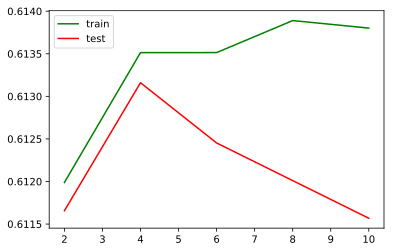

In [59]:
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=1, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])
best_param, _ = grid_serach(lg_pipe, {'logit__C': np.linspace(2, 10, 5)})

In [60]:
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=4, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])
cross_val(lg_pipe)

['oscilo']
Mean score = 0.613, score std = 0.00820


array([ 0.60326567,  0.60415745,  0.62229102,  0.62168142,  0.61443116])

['oscilo']
{'logit__C': 10.0, 'poly__degree': 5} 0.705138409835


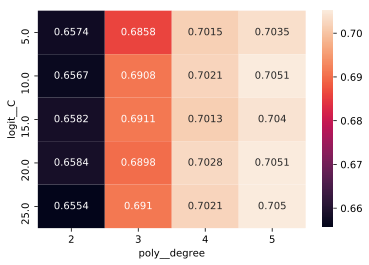

In [114]:
lg_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                    ('scaler', StandardScaler()),
                    ('logit', LogisticRegression(C=1, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])
best_param, _ = grid_serach(lg_pipe, {'logit__C': np.linspace(5, 25, 5),
                                      'poly__degree': np.linspace(2, 5, 4, dtype='int')})

In [115]:
lg_pipe = Pipeline([('poly', PolynomialFeatures(degree=5)),
                    ('scaler', StandardScaler()),
                    ('logit', LogisticRegression(C=10, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])
cross_val(lg_pipe)

['oscilo']
Mean score = 0.705, score std = 0.00333


array([ 0.70344219,  0.7023441 ,  0.71163202,  0.70353982,  0.70473661])

['spec']
{'logit__C': 10.0} 0.819757672238


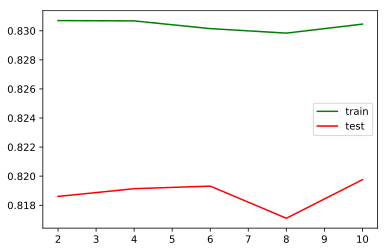

In [120]:
%%time
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=1, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])
best_param, _ = grid_serach(lg_pipe, {'logit__C': np.linspace(2, 10, 5)}, ['spec'])

In [121]:
%%time
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=5, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])
cross_val(lg_pipe, ['spec'])

['spec']
Mean score = 0.820, score std = 0.00654


array([ 0.82082966,  0.82662539,  0.82220257,  0.80752212,  0.8229305 ])

['oscilo', 'spec']
{'logit__C': 5} 0.879366763952


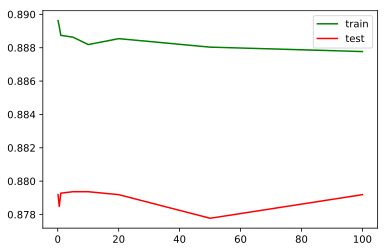

In [43]:
%%time
#Без фильтра
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=1, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])
best_param, _ = grid_serach(lg_pipe, {'logit__C': [0.1, 0.5, 1, 5, 10, 20, 50, 100]}, ['oscilo', 'spec'])

In [44]:
%%time
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=5, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])
cross_val(lg_pipe, ['oscilo', 'spec'])

['oscilo', 'spec']
Mean score = 0.879, score std = 0.00767


array([ 0.8874669 ,  0.88323751,  0.87881468,  0.86504425,  0.88224878])

['oscilo', 'spec']
{'logit__C': 0.5} 0.894047934908


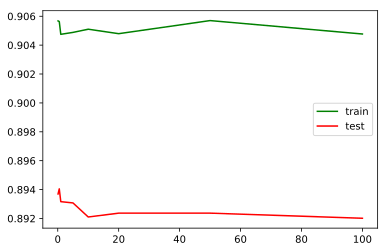

In [96]:
%%time
#С фильтром
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=1, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])
best_param, _ = grid_serach(lg_pipe, {'logit__C': [0.1, 0.5, 1, 5, 10, 20, 50, 100]}, ['oscilo', 'spec'])

In [97]:
%%time
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=5, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])
cross_val(lg_pipe, ['oscilo', 'spec'])

['oscilo', 'spec']
Mean score = 0.893, score std = 0.00567


array([ 0.9011474 ,  0.89164087,  0.89739054,  0.89026549,  0.88490483])

['oscilo', 'spec']
{'logit__C': 10} 0.911028566375
Wall time: 26min 27s


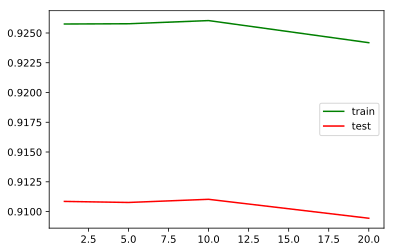

In [121]:
%%time
#С фильтром
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=1, penalty='l2', solver='lbfgs',
                                                 multi_class='ovr', n_jobs=-1, random_state=17))])
best_param, _ = grid_serach(lg_pipe, {'logit__C': [1, 5, 10, 20]}, ['oscilo', 'spec'])

In [ ]:
%%time
#С фильтром
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=5, penalty='l2', solver='lbfgs',
                                                 multi_class='ovr', n_jobs=-1, random_state=17))])
cross_val(lg_pipe, ['oscilo', 'spec'])

In [20]:
%%time
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('pca', PCA(n_components=.9)),
                    ('logit', LogisticRegression(C=5, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])
cross_val(lg_pipe, ['oscilo', 'spec'])
#best_param, _ = grid_serach(lg_pipe, {'pca__n_components': np.linspace(0.85, 0.95, 3)}, ['oscilo', 'spec'])

['oscilo', 'spec']
Mean score = 0.539, score std = 0.00586


array([ 0.54457193,  0.536046  ,  0.53427687,  0.53185841,  0.54670208])

['oscilo', 'spec']
{'ovr__estimator__alpha': 0.1} 0.90262669143


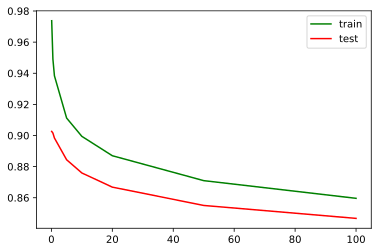

In [41]:
%%time
#Без фильтра
rg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('ovr', OneVsRestClassifier(Ridge(alpha=1, solver='auto', random_state=17), n_jobs=-1))])
best_param, _ = grid_serach(rg_pipe, {'ovr__estimator__alpha': [0.1, 0.5, 1, 5, 10, 20, 50, 100]}, ['oscilo', 'spec'])

In [42]:
%%time
rg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('ovr', OneVsRestClassifier(Ridge(alpha=5, solver='auto', random_state=17), n_jobs=-1))])
cross_val(rg_pipe, ['oscilo', 'spec'])

['oscilo', 'spec']
Mean score = 0.884, score std = 0.00532


array([ 0.8945278 ,  0.88412207,  0.87969925,  0.88053097,  0.88313413])

['oscilo', 'spec']
{'ovr__estimator__alpha': 0.5} 0.900946316441


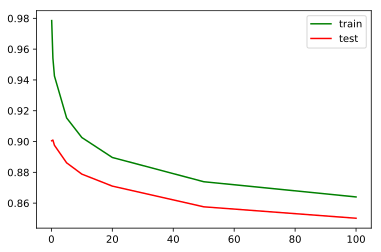

In [98]:
%%time
#С фильтром
rg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('ovr', OneVsRestClassifier(Ridge(alpha=1, solver='auto', random_state=17), n_jobs=-1))])
best_param, _ = grid_serach(rg_pipe, {'ovr__estimator__alpha': [0.1, 0.5, 1, 5, 10, 20, 50, 100]}, ['oscilo', 'spec'])

In [99]:
%%time
rg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('ovr', OneVsRestClassifier(Ridge(alpha=5, solver='auto', random_state=17), n_jobs=-1))])
cross_val(rg_pipe, ['oscilo', 'spec'])

['oscilo', 'spec']
Mean score = 0.886, score std = 0.00798


array([ 0.9015887 ,  0.88456435,  0.88102609,  0.87920354,  0.88446215])

['oscilo', 'spec']
{'ovr__estimator__alpha': 0.1} 0.531794463607


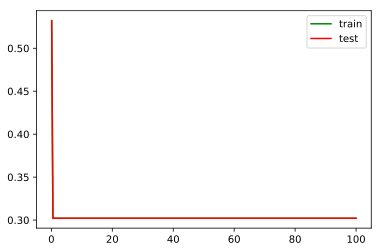

In [92]:
%%time
#С фильтром
ls_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('ovr', OneVsRestClassifier(Lasso(alpha=1, random_state=17), n_jobs=-1))])

best_param, _ = grid_serach(ls_pipe, {'ovr__estimator__alpha': [0.1, 0.5, 1, 5, 10, 20, 50, 100]}, ['oscilo', 'spec'])

In [93]:
%%time
ls_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('ovr', OneVsRestClassifier(Lasso(alpha=1, random_state=17), n_jobs=-1))])
cross_val(ls_pipe, ['oscilo', 'spec'])

['oscilo', 'spec']
Mean score = 0.302, score std = 0.00016


array([ 0.30185349,  0.30207873,  0.30207873,  0.30221239,  0.30234617])

['oscilo', 'spec']
{'svc__C': 100} 0.986291677722


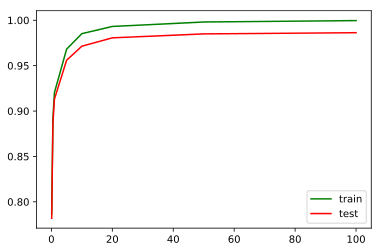

In [101]:
%%time
#С фильтром
svc_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('svc', SVC(C=1.0, kernel='rbf', gamma='auto',
                                 decision_function_shape='ovr', random_state=17))])
best_param, _ = grid_serach(svc_pipe, {'svc__C': [0.1, 0.5, 1, 5, 10, 20, 50, 100]}, ['oscilo', 'spec'])

In [103]:
%%time
svc_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('svc', SVC(C=10, kernel='rbf', gamma='auto',
                                 decision_function_shape='ovr', random_state=17))])
cross_val(svc_pipe, ['oscilo', 'spec'])

['oscilo', 'spec']
Mean score = 0.971, score std = 0.00487


array([ 0.97087379,  0.96682884,  0.97965502,  0.96637168,  0.97343958])

In [303]:
%%time
linsvc_pipe = Pipeline([('scaler', StandardScaler()), 
                        ('linsvc', LinearSVC(C=10, penalty='l2', loss='squared_hinge',
                                             multi_class='ovr', random_state=17))])
cross_val(linsvc_pipe, ['oscilo', 'spec'])

['oscilo', 'spec']
Mean score = 0.899, score std = 0.01441
Wall time: 25min 17s


['oscilo', 'spec']
{'ovr__estimator__n_estimators': 250} 0.970018572566
Wall time: 59min 50s


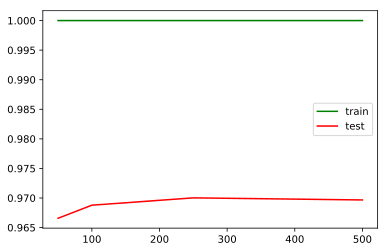

In [ ]:
%%time
fr_pipe = Pipeline([('ovr', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=17, n_jobs=-1),
                                                n_jobs=-1))])
best_param, _ = grid_serach(fr_pipe, {'ovr__estimator__n_estimators': [50, 100, 250, 500]}, ['oscilo', 'spec'])

In [21]:
%%time
fr_pipe = Pipeline([('ovr', OneVsRestClassifier(RandomForestClassifier(n_estimators=250, random_state=17, n_jobs=-1),
                                                n_jobs=-1))])
cross_val(fr_pipe, ['oscilo', 'spec'])

['oscilo', 'spec']
Mean score = 0.970, score std = 0.00503
Wall time: 15min 44s


In [ ]:
'''
%%time
gb_pipe = Pipeline([('ovr', OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, max_depth=3,
                                                                           random_state=17),
                                                n_jobs=-1))])
best_param, _ = grid_serach(gb_pipe, {'ovr__estimator__n_estimators': [50, 100, 250, 500]}, ['oscilo', 'spec'])
'''

In [ ]:
import time

for n_estimators in [50, 100, 250, 500]:
    gb_pipe = Pipeline([('ovr', OneVsRestClassifier(GradientBoostingClassifier(n_estimators=n_estimators, max_depth=3,
                                                                               random_state=17),
                                                    n_jobs=-1))])
    print('n_estimators =', n_estimators);
    tic = time.time()
    cross_val(gb_pipe, ['oscilo', 'spec'])
    toc = time.time()
    print(toc - tic)

n_estimators = 50
['oscilo', 'spec']
Mean score = 0.949, score std = 0.00494
4762.74889922142
n_estimators = 100
['oscilo', 'spec']
Mean score = 0.965, score std = 0.00342
9321.606642007828
n_estimators = 250


In [21]:
%%time
gb_pipe = Pipeline([('ovr', OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, max_depth=3,
                                                                           random_state=17),
                                                n_jobs=-1))])
cross_val(gb_pipe, ['oscilo', 'spec'])

['oscilo', 'spec']
Mean score = 0.965, score std = 0.00342
Wall time: 2h 38min 47s


In [25]:
import xgboost as xgb
import time

In [26]:
%%time
xgb_params = {'booster': 'gbtree', 'max_depth': 3, 'eta': 0.1,
              'silent': 1, 'objective': 'multi:softprob', 'num_class': len(d_class) - 1, 'nthread': 8}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

mode_list = ['oscilo', 'spec']
X, y, _, _ = get_data(mode_list)

print(mode_list)
for n_estimators in [50, 100, 250, 500]:
    train_acc = []
    valid_acc = []
    
    print()
    print('n_estimators =', n_estimators);
    tic = time.time()
    for train_idx, valid_idx  in skf.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]

        dtrain = xgb.DMatrix(X_train, y_train)
        dvalid = xgb.DMatrix(X_valid)

        xgb_model = xgb.train(xgb_params, dtrain, n_estimators)
        proba_train = xgb_model.predict(dtrain)
        proba_valid = xgb_model.predict(dvalid)

        train_acc.append(accuracy_score(y_train, [np.argmax(probas) for probas in proba_train]))
        valid_acc.append(accuracy_score(y_valid, [np.argmax(probas) for probas in proba_valid]))
    toc = time.time()
    
    print('Wall time: %s' % time.strftime('%Hh %Mmin %Ss', time.gmtime(toc - tic)))
    print('Train accuracy: ', np.array(train_acc))
    print('Valid accuracy: ', np.array(valid_acc))
    print('Mean score = %.3f, score std = %.5f' % (np.mean(valid_acc), np.std(valid_acc)))

['oscilo', 'spec']

n_estimators = 50
Wall time: 00h 49min 02s
Train accuracy:  [ 0.95807986  0.96175105  0.95865576  0.96098154  0.95988064]
Valid accuracy:  [ 0.93027361  0.93896506  0.9429456   0.93849558  0.93581231]
Mean score = 0.937, score std = 0.00419

n_estimators = 100
Wall time: 01h 34min 28s
Train accuracy:  [ 0.98916049  0.98927703  0.98850321  0.98883608  0.98994253]
Valid accuracy:  [ 0.96160635  0.9628483   0.97302079  0.96769912  0.96325808]
Mean score = 0.966, score std = 0.00421

n_estimators = 250
Wall time: 03h 45min 01s
Train accuracy:  [ 1.  1.  1.  1.  1.]
Valid accuracy:  [ 0.97661077  0.9800973   0.98584697  0.98274336  0.98052236]
Mean score = 0.981, score std = 0.00306

n_estimators = 500
Wall time: 06h 46min 11s
Train accuracy:  [ 1.  1.  1.  1.  1.]
Valid accuracy:  [ 0.98234775  0.98319328  0.98628925  0.98539823  0.98450642]
Mean score = 0.984, score std = 0.00143
Wall time: 12h 54min 45s


In [117]:
class TwoLayerNet(object):

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = None
        b1 = b1.reshape(1, -1)
        sc_NH = X.dot(W1) + b1
        sc_NH_ReLU = np.maximum(0, sc_NH)
        b2 = b2.reshape(1, -1)
        sc_NH_ReLU_NC = sc_NH_ReLU.dot(W2) + b2
        scores = sc_NH_ReLU_NC

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = None
        if np.any(np.isinf(scores)) or np.any(np.isnan(scores)):
            return (np.inf, {'W1': 1e-4 * np.random.randn(W1.shape[0], W1.shape[1]), 'b1': np.zeros(b1.shape[0]).reshape(-1), \
                             'W2': 1e-4 * np.random.randn(W2.shape[0], W2.shape[1]), 'b2': np.zeros(b2.shape[0]).reshape(-1)})
    
        idx = (np.arange(N), y)
        #log-sum-exp trick
        C = np.max(scores, axis=1).reshape(-1, 1)
        scores -= C
        scores = np.maximum(-20, scores)
        #
        scores = np.exp(scores)
        denominators = np.sum(scores, axis=1).reshape(-1, 1)
        probs = scores / denominators
        loss = np.sum(-np.log(probs[idx]))
        loss /= N
        loss += reg * (np.sum(W1 * W1) + np.sum(W2 * W2))

        # Backward pass: compute gradients
        grads = {}
        grads['W1'] = np.zeros_like(W1)
        grads['b1'] = np.zeros_like(b1)
        grads['W2'] = np.zeros_like(W2)
        grads['b2'] = np.zeros_like(b2)

        # after softmax
        upstr_grad = 1.00

        grads['W1'] += 2 * reg * W1
        grads['W2'] += 2 * reg * W2

        upstr_grad /= N

        # sc_NH_ReLU_NC
        loc_grad = probs
        loc_grad[idx] -= 1 # probs ~ scores ~ sc_NH_ReLU_NC
        upstr_grad = loc_grad * upstr_grad # NC
        grads['b2'] += np.sum(upstr_grad, axis=0) # NC -> 1C

        # sc_NH_ReLU W2
        loc_grad = sc_NH_ReLU
        upstr_grad_W2 = (loc_grad.T).dot(upstr_grad) # HN*NC=HC
        grads['W2'] += upstr_grad_W2

        # sc_NH_ReLU ReLU
        loc_grad = W2
        upstr_grad = upstr_grad.dot(loc_grad.T) # NC*CH=NH

        # sc_NH ReLU
        loc_grad = np.zeros_like(sc_NH)
        loc_grad[sc_NH > 0] = 1
        upstr_grad = loc_grad * upstr_grad # NH

        # sc_NH
        grads['b1'] += np.sum(upstr_grad, axis=0) # NH -> 1H
        grads['W1'] += (X.T).dot(upstr_grad) # DN*NH=DH

        # return shape
        grads['b1'] = grads['b1'].reshape(-1)
        grads['b2'] = grads['b2'].reshape(-1)

        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):  
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None

            idx = np.random.choice(num_train, size=batch_size, replace=True)
            X_batch = X[idx]
            y_batch = y[idx]

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            for key, value in grads.items():
                self.params[key] -= learning_rate * value

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
        'loss_history': loss_history,
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        y_pred = None
        scores = X.dot(self.params['W1']) + self.params['b1'].reshape(1 , -1)
        scores = np.maximum(0, scores)
        scores = scores.dot(self.params['W2']) + self.params['b2'].reshape(1, -1)
        y_pred = np.argmax(scores, axis=1)

        return y_pred
    
    def predict_proba(self, X):
        y_pred_proba = None
        scores = X.dot(self.params['W1']) + self.params['b1'].reshape(1 , -1)
        scores = np.maximum(0, scores)
        scores = scores.dot(self.params['W2']) + self.params['b2'].reshape(1, -1)
        #log-sum-exp trick
        C = np.max(scores, axis=1).reshape(-1, 1)
        scores -= C
        scores = np.maximum(-20, scores)
        #
        scores = np.exp(scores)
        denominators = np.sum(scores, axis=1).reshape(-1, 1)
        y_pred_proba = scores / denominators

        return y_pred_proba

iteration 0 / 1000: loss 38.970977
iteration 100 / 1000: loss 35.794646
iteration 200 / 1000: loss 34.235377
iteration 300 / 1000: loss 33.833555
iteration 400 / 1000: loss 33.687766
iteration 500 / 1000: loss 33.585823
iteration 600 / 1000: loss 33.194281
iteration 700 / 1000: loss 33.338459
iteration 800 / 1000: loss 33.187275
iteration 900 / 1000: loss 33.122003
Train accuracy:  0.591315114531
Final training loss:  33.0218755609


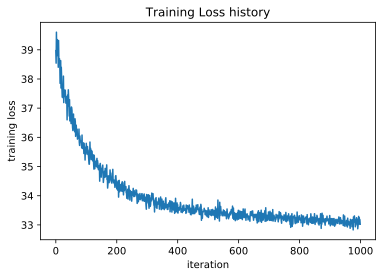

Wall time: 30.8 s


In [81]:
%%time
mode_list = ['oscilo', 'spec']
X, y, _, _ = get_data(mode_list)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

np.random.seed(17)
net = TwoLayerNet(X.shape[1], 5*(len(d_class) - 1), len(d_class) - 1, std=1e-1)

stats = net.train(X_scaled, y, X_scaled, y,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.01, verbose=True)

print('Train accuracy: ', (net.predict(X_scaled) == y).mean())
print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

In [180]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

mode_list = ['oscilo', 'spec']
X, y, _, _ = get_data(mode_list)

input_size = X.shape[1]
num_classes = len(d_class) - 1
np.random.seed(17)

def score(params):
    print("Training with params:")
    params['hidden_size'] = int(params['hidden_size'])
    params['num_iters'] = int(params['num_iters'])
    params['batch_size'] = int(params['batch_size'])
    print(params)
    hidden_size = params.pop('hidden_size')
    
    train_acc = []
    valid_acc = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
    for train_idx, valid_idx in skf.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)
        
        net = TwoLayerNet(input_size, hidden_size, num_classes)
        net.train(X_train_scaled, y_train, X_valid_scaled, y_valid, **params)
        
        train_acc.append(np.mean(net.predict(X_train_scaled) == y_train))
        valid_acc.append(np.mean(net.predict(X_valid_scaled) == y_valid))
    
    print('train accuracy: %f, valid accuracy: %f' % (np.mean(train_acc), np.mean(valid_acc)))
    return {'loss': 1 - np.min(valid_acc), 'status': STATUS_OK}

def optimize(trials):
    space = {
             'hidden_size': hp.quniform('hidden_size', num_classes, 50*num_classes, num_classes),
             'learning_rate': hp.qloguniform('learning_rate', np.log(1e-4), np.log(1e-1), 1e-4),
             'reg': hp.qloguniform('reg', np.log(1e-4), np.log(1e-1), 1e-4),
             'num_iters': hp.quniform('num_iters', 60, 1000, 100),
             'batch_size': hp.choice('batch_size', [200])
             }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=100)
    return best

trials = Trials()
best_params = optimize(trials)
best_params['batch_size'] = 200
params = best_params.copy()
params

Training with params:
{'batch_size': 200, 'hidden_size': 24, 'learning_rate': 0.0013000000000000002, 'num_iters': 300, 'reg': 0.0771}
train accuracy: 0.330630, valid accuracy: 0.331060
Training with params:
{'batch_size': 200, 'hidden_size': 72, 'learning_rate': 0.0099, 'num_iters': 300, 'reg': 0.0006000000000000001}
train accuracy: 0.691341, valid accuracy: 0.690103
Training with params:
{'batch_size': 200, 'hidden_size': 296, 'learning_rate': 0.0023, 'num_iters': 400, 'reg': 0.0001}
train accuracy: 0.460025, valid accuracy: 0.459979
Training with params:
{'batch_size': 200, 'hidden_size': 144, 'learning_rate': 0.0037, 'num_iters': 600, 'reg': 0.016}
train accuracy: 0.644911, valid accuracy: 0.643491
Training with params:
{'batch_size': 200, 'hidden_size': 232, 'learning_rate': 0.0029000000000000002, 'num_iters': 500, 'reg': 0.0014}
train accuracy: 0.538981, valid accuracy: 0.539753
Training with params:
{'batch_size': 200, 'hidden_size': 248, 'learning_rate': 0.00030000000000000003, 

D:\MyDisk\Python\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in subtract


train accuracy: 0.225247, valid accuracy: 0.226543
Training with params:
{'batch_size': 200, 'hidden_size': 168, 'learning_rate': 0.012400000000000001, 'num_iters': 800, 'reg': 0.0004}
train accuracy: 0.826126, valid accuracy: 0.820197
Training with params:
{'batch_size': 200, 'hidden_size': 312, 'learning_rate': 0.0284, 'num_iters': 600, 'reg': 0.0008}
train accuracy: 0.873022, valid accuracy: 0.867425
Training with params:
{'batch_size': 200, 'hidden_size': 256, 'learning_rate': 0.0053, 'num_iters': 1000, 'reg': 0.0001}
train accuracy: 0.742085, valid accuracy: 0.738743
Training with params:
{'batch_size': 200, 'hidden_size': 216, 'learning_rate': 0.001, 'num_iters': 900, 'reg': 0.0002}
train accuracy: 0.457991, valid accuracy: 0.457856
Training with params:
{'batch_size': 200, 'hidden_size': 128, 'learning_rate': 0.0029000000000000002, 'num_iters': 700, 'reg': 0.0021000000000000003}
train accuracy: 0.629987, valid accuracy: 0.628630
Training with params:
{'batch_size': 200, 'hidden_

train accuracy: 0.779761, valid accuracy: 0.775181
Training with params:
{'batch_size': 200, 'hidden_size': 264, 'learning_rate': 0.0053, 'num_iters': 400, 'reg': 0.0004}
train accuracy: 0.639649, valid accuracy: 0.639071
Training with params:
{'batch_size': 200, 'hidden_size': 360, 'learning_rate': 0.07300000000000001, 'num_iters': 1000, 'reg': 0.007500000000000001}
train accuracy: 0.641490, valid accuracy: 0.627988
Training with params:
{'batch_size': 200, 'hidden_size': 96, 'learning_rate': 0.0012000000000000001, 'num_iters': 800, 'reg': 0.0007}
train accuracy: 0.458079, valid accuracy: 0.457504
Training with params:
{'batch_size': 200, 'hidden_size': 336, 'learning_rate': 0.0118, 'num_iters': 900, 'reg': 0.010700000000000001}
train accuracy: 0.833444, valid accuracy: 0.828954
Training with params:
{'batch_size': 200, 'hidden_size': 392, 'learning_rate': 0.0407, 'num_iters': 500, 'reg': 0.001}
train accuracy: 0.877313, valid accuracy: 0.871311
Training with params:
{'batch_size': 20

{'batch_size': 200,
 'hidden_size': 240.0,
 'learning_rate': 0.0284,
 'num_iters': 1000.0,
 'reg': 0.0011}

In [181]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=17)

mode_list = ['oscilo', 'spec']
X, y, _, _ = get_data(mode_list)

cls_list = ['logit', 'svc', 'rfc', 'gbc', 'nnc']
train_proba = {}
valid_proba = {}
for cls in cls_list:
    train_proba[cls] = n_splits * [None]
    valid_proba[cls] = n_splits * [None]

params['hidden_size'] = int(params['hidden_size'])
params['num_iters'] = int(params['num_iters']) + 1
params['batch_size'] = int(params['batch_size'])
input_size = X.shape[1]
hidden_size = params.pop('hidden_size')
num_classes = len(d_class) - 1
    
print(mode_list)
print()
for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print('Path #', i+1)
    tic = time.time()
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    tic_tic = time.time()
    logit = LogisticRegression(C=5, penalty='l2', solver='lbfgs', multi_class='ovr', n_jobs=-1, random_state=17)
    logit.fit(X_train_scaled, y_train)
    train_proba['logit'][i] = logit.predict_proba(X_train_scaled)
    valid_proba['logit'][i] = logit.predict_proba(X_valid_scaled)
    toc_toc = time.time()
    print('Logistic Regression: train acc = %.3f, valid acc = %.3f (%s)' %
          (accuracy_score(y_train, [np.argmax(probas) for probas in train_proba['logit'][i]]),
           accuracy_score(y_valid, [np.argmax(probas) for probas in valid_proba['logit'][i]]),
           time.strftime('%Hh %Mmin %Ss', time.gmtime(toc_toc - tic_tic))))
    
    tic_tic = time.time()
    svc = SVC(C=10, kernel='rbf', gamma='auto', decision_function_shape='ovr', random_state=17, probability=True)
    svc.fit(X_train_scaled, y_train)
    train_proba['svc'][i] = svc.predict_proba(X_train_scaled)
    valid_proba['svc'][i] = svc.predict_proba(X_valid_scaled)
    toc_toc = time.time()
    print('Support Vector Classifier: train acc = %.3f, valid acc = %.3f (%s)' %
          (accuracy_score(y_train, [np.argmax(probas) for probas in train_proba['svc'][i]]),
           accuracy_score(y_valid, [np.argmax(probas) for probas in valid_proba['svc'][i]]),
           time.strftime('%Hh %Mmin %Ss', time.gmtime(toc_toc - tic_tic))))

    tic_tic = time.time()
    rfc = OneVsRestClassifier(RandomForestClassifier(n_estimators=250, random_state=17, n_jobs=-1), n_jobs=-1)
    rfc.fit(X_train, y_train)
    train_proba['rfc'][i] = rfc.predict_proba(X_train)
    valid_proba['rfc'][i] = rfc.predict_proba(X_valid)
    toc_toc = time.time()
    print('Random Forest Classifier: train acc = %.3f, valid acc = %.3f (%s)' %
          (accuracy_score(y_train, [np.argmax(probas) for probas in train_proba['rfc'][i]]),
           accuracy_score(y_valid, [np.argmax(probas) for probas in valid_proba['rfc'][i]]),
           time.strftime('%Hh %Mmin %Ss', time.gmtime(toc_toc - tic_tic))))
    
    tic_tic = time.time()
    gbc = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=150, max_depth=3, random_state=17), n_jobs=-1)
    gbc.fit(X_train, y_train)
    train_proba['gbc'][i] = gbc.predict_proba(X_train)
    valid_proba['gbc'][i] = gbc.predict_proba(X_valid)
    toc_toc = time.time()
    print('Gradient Boosting Classifier: train acc = %.3f, valid acc = %.3f (%s)' %
          (accuracy_score(y_train, [np.argmax(probas) for probas in train_proba['gbc'][i]]),
           accuracy_score(y_valid, [np.argmax(probas) for probas in valid_proba['gbc'][i]]),
           time.strftime('%Hh %Mmin %Ss', time.gmtime(toc_toc - tic_tic))))

    tic_tic = time.time()
    np.random.seed(17)
    nnc = TwoLayerNet(input_size, hidden_size, num_classes)
    nnc.train(X_train_scaled, y_train, X_valid_scaled, y_valid, **params)
    train_proba['nnc'][i] = nnc.predict_proba(X_train_scaled)
    valid_proba['nnc'][i] = nnc.predict_proba(X_valid_scaled)
    toc_toc = time.time()
    print('Two Layer Net: train acc = %.3f, valid acc = %.3f (%s)' %
          (accuracy_score(y_train, [np.argmax(probas) for probas in train_proba['nnc'][i]]),
           accuracy_score(y_valid, [np.argmax(probas) for probas in valid_proba['nnc'][i]]),
           time.strftime('%Hh %Mmin %Ss', time.gmtime(toc_toc - tic_tic))))
    
    toc = time.time()
    print('Wall time: %s' % time.strftime('%Hh %Mmin %Ss', time.gmtime(toc - tic)))
    print()

['oscilo', 'spec']

Path # 1
Logistic Regression: train acc = 0.923, valid acc = 0.912 (00h 04min 41s)
Support Vector Classifier: train acc = 0.987, valid acc = 0.973 (00h 12min 31s)
Random Forest Classifier: train acc = 1.000, valid acc = 0.967 (00h 03min 09s)
Gradient Boosting Classifier: train acc = 0.998, valid acc = 0.967 (00h 43min 01s)
Two Layer Net: train acc = 0.898, valid acc = 0.885 (00h 01min 26s)
Wall time: 01h 04min 52s

Path # 2
Logistic Regression: train acc = 0.929, valid acc = 0.913 (00h 04min 32s)
Support Vector Classifier: train acc = 0.988, valid acc = 0.968 (00h 12min 27s)
Random Forest Classifier: train acc = 1.000, valid acc = 0.966 (00h 03min 11s)
Gradient Boosting Classifier: train acc = 0.998, valid acc = 0.973 (00h 43min 23s)
Two Layer Net: train acc = 0.928, valid acc = 0.913 (00h 01min 27s)
Wall time: 01h 05min 06s

Path # 3
Logistic Regression: train acc = 0.929, valid acc = 0.908 (00h 04min 23s)
Support Vector Classifier: train acc = 0.987, valid acc = 0

In [184]:
copy_valid_proba = valid_proba.copy()

In [187]:
for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print('Path #', i+1)
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    '''
    print('Logistic Regression: train acc = %.3f, valid acc = %.3f' %
          (accuracy_score(y_train, [np.argmax(probas) for probas in train_proba['logit'][i]]),
           accuracy_score(y_valid, [np.argmax(probas) for probas in valid_proba['logit'][i]])))
    print('Support Vector Classifier: train acc = %.3f, valid acc = %.3f' %
          (accuracy_score(y_train, [np.argmax(probas) for probas in train_proba['svc'][i]]),
           accuracy_score(y_valid, [np.argmax(probas) for probas in valid_proba['svc'][i]])))
    print('Random Forest Classifier: train acc = %.3f, valid acc = %.3f' %
          (accuracy_score(y_train, [np.argmax(probas) for probas in train_proba['rfc'][i]]),
           accuracy_score(y_valid, [np.argmax(probas) for probas in valid_proba['rfc'][i]])))
    print('Gradient Boosting Classifier: train acc = %.3f, valid acc = %.3f' %
          (accuracy_score(y_train, [np.argmax(probas) for probas in train_proba['gbc'][i]]),
           accuracy_score(y_valid, [np.argmax(probas) for probas in valid_proba['gbc'][i]])))
    print('Two Layer Net: train acc = %.3f, valid acc = %.3f' %
          (accuracy_score(y_train, [np.argmax(probas) for probas in train_proba['nnc'][i]]),
           accuracy_score(y_valid, [np.argmax(probas) for probas in valid_proba['nnc'][i]])))
   '''

Path # 1
Logistic Regression: train acc = 0.923, valid acc = 0.912
Support Vector Classifier: train acc = 0.987, valid acc = 0.973
Random Forest Classifier: train acc = 1.000, valid acc = 0.967
Gradient Boosting Classifier: train acc = 0.998, valid acc = 0.967
Two Layer Net: train acc = 0.898, valid acc = 0.885
Path # 2
Logistic Regression: train acc = 0.929, valid acc = 0.913
Support Vector Classifier: train acc = 0.988, valid acc = 0.968
Random Forest Classifier: train acc = 1.000, valid acc = 0.966
Gradient Boosting Classifier: train acc = 0.998, valid acc = 0.973
Two Layer Net: train acc = 0.928, valid acc = 0.913
Path # 3
Logistic Regression: train acc = 0.929, valid acc = 0.908
Support Vector Classifier: train acc = 0.987, valid acc = 0.982
Random Forest Classifier: train acc = 1.000, valid acc = 0.979
Gradient Boosting Classifier: train acc = 0.998, valid acc = 0.979
Two Layer Net: train acc = 0.913, valid acc = 0.920
Path # 4
Logistic Regression: train acc = 0.927, valid acc = 

In [326]:
(np.expand_dims(valid_proba['nnc'][0], axis=2) * np.linspace(0.0, 1.0, 11))[:,:,10]

array([[  9.24351551e-01,   7.94365777e-05,   6.76655935e-05, ...,
          2.36951462e-05,   1.15871371e-02,   5.05481513e-04],
       [  9.73761895e-01,   2.16837959e-04,   2.90706436e-04, ...,
          2.30037991e-05,   5.46881846e-03,   1.91111236e-04],
       [  9.83550213e-01,   1.98744197e-03,   1.50810531e-03, ...,
          3.40707144e-05,   4.49984914e-04,   2.00635647e-03],
       ..., 
       [  6.92697543e-02,   5.54802642e-01,   7.67298030e-03, ...,
          1.95723153e-03,   1.01035357e-03,   3.29382050e-01],
       [  2.91471950e-02,   6.31776612e-03,   7.48486002e-02, ...,
          1.06004124e-02,   8.03580179e-02,   7.88959960e-01],
       [  3.37279117e-01,   8.90076220e-04,   1.86179501e-01, ...,
          4.89418574e-04,   2.81493089e-01,   5.89164893e-02]])

In [350]:
np.dstack([[[1, 2],[3, 4]], [[5, 6],[7, 8]]])

array([[[1, 5],
        [2, 6]],

       [[3, 7],
        [4, 8]]])

In [353]:
#np.dstack(valid_proba['nnc'])

In [355]:
for i in range(len(valid_proba['nnc'])):
    print(valid_proba['nnc'][i].shape)

(2266, 8)
(2261, 8)
(2261, 8)
(2260, 8)
(2259, 8)


In [328]:
param_grid = np.linspace(0.0, 1.0, 11)

valid_accuracy = np.zeros(tuple([n_splits] + [11]*(len(cls_list) - 1)))

for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print('Path #', i+1, end=' ')
    tic = time.time()
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    for j, alpha in enumerate(param_grid):
        for k, beta in enumerate(param_grid):
            for m, gamma in enumerate(param_grid):
                for n, delta in enumerate(param_grid):
                    ensemble_proba = delta*(gamma*(beta*(alpha*valid_proba['rfc'][i] \
                                                         + (1.0 - alpha)*valid_proba['gbc'][i]) \
                                                   + (1.0 - beta)*valid_proba['svc'][i]) \
                                            + (1.0 - gamma)*valid_proba['logit'][i]) \
                                     + (1.0 - delta)*valid_proba['nnc'][i]
                    valid_accuracy[i][j][k][m][n] = \
                        accuracy_score(y_valid, [np.argmax(probas) for probas in ensemble_proba])
    toc = time.time()
    print('(Wall time: %s)' % time.strftime('%Hh %Mmin %Ss', time.gmtime(toc - tic)))

Path # 1 (Wall time: 00h 01min 17s)
Path # 2 (Wall time: 00h 01min 13s)
Path # 3 (Wall time: 00h 01min 12s)
Path # 4 (Wall time: 00h 01min 12s)
Path # 5 (Wall time: 00h 01min 12s)


In [215]:
#'logit', 'svc', 'rfc', 'gbc', 'nnc'
mean_valid_accuracy = np.mean(valid_accuracy, axis=0)
arg_max_ravel = np.argmax(mean_valid_accuracy)
idx = np.unravel_index(arg_max_ravel, tuple([11]*(len(cls_list) - 1)))
mean_valid_accuracy[idx], idx

(0.98452358650059835, (2, 7, 6, 10))

In [217]:
#'logit', 'nnc', 'rfc', 'gbc', 'svc'
mean_valid_accuracy = np.mean(valid_accuracy, axis=0)
arg_max_ravel = np.argmax(mean_valid_accuracy)
idx = np.unravel_index(arg_max_ravel, tuple([11]*(len(cls_list) - 1)))
mean_valid_accuracy[idx], idx

(0.98434753270710651, (10, 3, 5, 7))

In [329]:
#'rfc', 'gbc', 'svc', 'logit', 'nnc'
mean_valid_accuracy = np.mean(valid_accuracy, axis=0)
arg_max_ravel = np.argmax(mean_valid_accuracy)
idx = np.unravel_index(arg_max_ravel, tuple([11]*(len(cls_list) - 1)))
mean_valid_accuracy[idx], idx

(0.98443540297448506, (4, 7, 9, 10))

In [380]:
arg_max_ravel = np.argmax(mean_valid_accuracy[:,:,0,:])
idx = np.unravel_index(arg_max_ravel, tuple([11]*len(mean_valid_accuracy.shape)))
mean_valid_accuracy[idx], idx

(0.93084087247219394, (0, 0, 0, 6))

In [376]:
mva = mean_valid_accuracy[:,:,0,:]
arg_max_ravel = np.argmax(mva)
idx = np.unravel_index(arg_max_ravel, tuple([11]*len(mva.shape)))
mva[idx], idx

(0.93084087247219394, (0, 0, 6))

In [381]:
mean_valid_accuracy[0,0,0,6]

0.93084087247219394

In [382]:
param_grid = np.linspace(0.0, 1.0, 11)

valid_accuracy = np.zeros(tuple([n_splits] + [11]*(len(cls_list) - 2)))

for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print('Path #', i+1, end=' ')
    tic = time.time()
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    for j, alpha in enumerate(param_grid):
        for k, beta in enumerate(param_grid):
            for m, gamma in enumerate(param_grid):
                ensemble_proba = gamma*(beta*(alpha*valid_proba['logit'][i] \
                                              + (1.0 - alpha)*valid_proba['rfc'][i]) \
                                        + (1.0 - beta)*valid_proba['gbc'][i]) \
                                 + (1.0 - gamma)*valid_proba['svc'][i]
                valid_accuracy[i][j][k][m] = \
                    accuracy_score(y_valid, [np.argmax(probas) for probas in ensemble_proba])
    toc = time.time()
    print('(Wall time: %s)' % time.strftime('%Hh %Mmin %Ss', time.gmtime(toc - tic)))

Path # 1 (Wall time: 00h 00min 06s)
Path # 2 (Wall time: 00h 00min 06s)
Path # 3 (Wall time: 00h 00min 06s)
Path # 4 (Wall time: 00h 00min 06s)
Path # 5 (Wall time: 00h 00min 06s)


In [225]:
#'logit', 'svc', 'rfc', 'gbc'
mean_valid_accuracy = np.mean(valid_accuracy, axis=0)
arg_max_ravel = np.argmax(mean_valid_accuracy)
idx = np.unravel_index(arg_max_ravel, tuple([11]*(len(cls_list) - 2)))
mean_valid_accuracy[idx], idx

(0.98452358650059835, (2, 7, 6))

In [383]:
#'logit', 'rfc', 'gbc', 'svc'
mean_valid_accuracy = np.mean(valid_accuracy, axis=0)
arg_max_ravel = np.argmax(mean_valid_accuracy)
idx = np.unravel_index(arg_max_ravel, tuple([11]*(len(cls_list) - 2)))
mean_valid_accuracy[idx], idx

(0.98434753270710651, (3, 5, 7))

In [387]:
param_grid = np.linspace(0.0, 1.0, 11)

valid_accuracy = np.zeros(tuple([n_splits] + [11]*(len(cls_list) - 3)))

for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print('Path #', i+1, end=' ')
    tic = time.time()
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    for j, alpha in enumerate(param_grid):
        for k, beta in enumerate(param_grid):
            ensemble_proba = beta*(alpha*valid_proba['svc'][i] \
                                   + (1.0 - alpha)*valid_proba['rfc'][i]) \
                             + (1.0 - beta)*valid_proba['logit'][i]
            valid_accuracy[i][j][k] = \
                accuracy_score(y_valid, [np.argmax(probas) for probas in ensemble_proba])
    toc = time.time()
    print('(Wall time: %s)' % time.strftime('%Hh %Mmin %Ss', time.gmtime(toc - tic)))

Path # 1 (Wall time: 00h 00min 00s)
Path # 2 (Wall time: 00h 00min 00s)
Path # 3 (Wall time: 00h 00min 00s)
Path # 4 (Wall time: 00h 00min 00s)
Path # 5 (Wall time: 00h 00min 00s)


In [386]:
#'logit', 'rfc', 'svc'
mean_valid_accuracy = np.mean(valid_accuracy, axis=0)
arg_max_ravel = np.argmax(mean_valid_accuracy)
idx = np.unravel_index(arg_max_ravel, tuple([11]*(len(cls_list) - 3)))
mean_valid_accuracy[idx], idx

(0.98063267167875168, (3, 7))

In [388]:
#'svc', 'rfc', 'logit'
mean_valid_accuracy = np.mean(valid_accuracy, axis=0)
arg_max_ravel = np.argmax(mean_valid_accuracy)
idx = np.unravel_index(arg_max_ravel, tuple([11]*(len(cls_list) - 3)))
mean_valid_accuracy[idx], idx

(0.98019054495711655, (4, 8))

In [389]:
param_grid = np.linspace(0.0, 1.0, 11)

valid_accuracy = np.zeros(tuple([n_splits] + [11]*(len(cls_list) - 4)))

for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print('Path #', i+1, end=' ')
    tic = time.time()
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    for j, alpha in enumerate(param_grid):
        ensemble_proba = alpha*valid_proba['svc'][i] + (1.0 - alpha)*valid_proba['rfc'][i]
        valid_accuracy[i][j] = \
            accuracy_score(y_valid, [np.argmax(probas) for probas in ensemble_proba])
    toc = time.time()
    print('(Wall time: %s)' % time.strftime('%Hh %Mmin %Ss', time.gmtime(toc - tic)))

Path # 1 (Wall time: 00h 00min 00s)
Path # 2 (Wall time: 00h 00min 00s)
Path # 3 (Wall time: 00h 00min 00s)
Path # 4 (Wall time: 00h 00min 00s)
Path # 5 (Wall time: 00h 00min 00s)


In [390]:
#'svc', 'rfc'
mean_valid_accuracy = np.mean(valid_accuracy, axis=0)
arg_max_ravel = np.argmax(mean_valid_accuracy)
idx = np.unravel_index(arg_max_ravel, tuple([11]*(len(cls_list) - 4)))
mean_valid_accuracy[idx], idx

(0.97859840564098466, (4,))

In [278]:
param_grid = np.linspace(0.0, 1.0, 11)
hyper_params = {}
for key, index in zip(['alpha', 'beta', 'gamma'], idx):
    hyper_params[key] = param_grid[index]

false_proba_predict = []
for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    ensemble_proba = hyper_params['gamma']*(hyper_params['beta']*(hyper_params['alpha']*valid_proba['logit'][i] \
                                                                  + (1.0 - hyper_params['alpha'])*valid_proba['rfc'][i]) \
                                            + (1.0 - hyper_params['beta'])*valid_proba['gbc'][i]) \
                     + (1.0 - hyper_params['gamma'])*valid_proba['svc'][i]

    ensemble_proba = np.array(ensemble_proba)
    ensemble_proba_predict = np.array([np.argmax(probas) for probas in ensemble_proba])
    false_proba_predict += np.array([ensemble_proba[i, cls] for i, cls in enumerate(ensemble_proba_predict)]) \
                           [y_valid != ensemble_proba_predict].tolist()

open_threshold = np.median(false_proba_predict)
print('threshold = %.4f' % open_threshold)

threshold = 0.5091


In [399]:
param_grid = np.linspace(0.0, 1.0, 11)
hyper_params = {}
for key, index in zip(['alpha'], idx):
    hyper_params[key] = param_grid[index]

false_proba_predict = []
for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    ensemble_proba = hyper_params['alpha']*valid_proba['svc'][i] + (1.0 - hyper_params['alpha'])*valid_proba['rfc'][i]

    ensemble_proba = np.array(ensemble_proba)
    ensemble_proba_predict = np.array([np.argmax(probas) for probas in ensemble_proba])
    false_proba_predict += np.array([ensemble_proba[i, cls] for i, cls in enumerate(ensemble_proba_predict)]) \
                           [y_valid != ensemble_proba_predict].tolist()

open_threshold = np.median(false_proba_predict)
print('threshold = %.4f' % open_threshold)

threshold = 0.5248


In [282]:
param_grid = np.linspace(0.0, 1.0, 11)
hyper_params = {}
for key, index in zip(['alpha', 'beta', 'gamma'], idx):
    hyper_params[key] = param_grid[index]

mode_list = ['oscilo', 'spec']
X_train, y_train, X_test, y_test = get_data(mode_list)

test_close_index = (df_test['Class'] != 'unknown').values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#logit = LogisticRegression(C=5, penalty='l2', solver='lbfgs', multi_class='ovr', n_jobs=-1, random_state=17)
#logit.fit(X_train_scaled, y_train)
logit_proba = logit.predict_proba(X_test_scaled)

#svc = SVC(C=10, kernel='rbf', gamma='auto', decision_function_shape='ovr', random_state=17, probability=True)
#svc.fit(X_train_scaled, y_train)
svc_proba = svc.predict_proba(X_test_scaled)

#rfc = OneVsRestClassifier(RandomForestClassifier(n_estimators=250, random_state=17, n_jobs=-1), n_jobs=-1)
#rfc.fit(X_train, y_train)
rfc_proba = rfc.predict_proba(X_test)

#gbc = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=150, max_depth=3, random_state=17), n_jobs=-1)
#gbc.fit(X_train, y_train)
gbc_proba = gbc.predict_proba(X_test)

ensemble_proba = hyper_params['gamma']*(hyper_params['beta']*(hyper_params['alpha']*logit_proba \
                                                              + (1.0 - hyper_params['alpha'])*rfc_proba) \
                                        + (1.0 - hyper_params['beta'])*gbc_proba) \
                 + (1.0 - hyper_params['gamma'])*svc_proba
        
ensemble_proba_predict = np.array([np.argmax(probas) for probas in ensemble_proba])

print(accuracy_score(y_test[test_close_index], ensemble_proba_predict[test_close_index]))
cfm_close = confusion_matrix(ensemble_proba_predict[test_close_index], y_test[test_close_index])
pd.DataFrame(np.vstack((cfm_close, cfm_close.sum(axis=0),
                        [round(cfm_close[i, i] / cfm_close.sum(axis=0)[i], ndigits=2) for i in range(cfm_close.shape[1])])),
             index=list(d_class.keys())[:-1] + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())[:-1]])

0.856236786469


,back,bags,door,keyb,knoc,ring,spee,tool
background,24.00,0.00,1.00,0.00,1.00,2.00,3.00,0.0
bags,0.00,37.00,0.00,2.00,0.00,0.00,0.00,0.0
door,2.00,3.00,43.00,2.00,6.00,0.00,4.00,0.0
keyboard,3.00,4.00,2.00,43.00,1.00,0.00,0.00,0.0
knocking_door,1.00,0.00,0.00,0.00,50.00,0.00,3.00,0.0
ring,0.00,0.00,0.00,0.00,0.00,70.00,0.00,0.0
speech,0.00,0.00,2.00,0.00,1.00,0.00,124.00,0.0
tool,11.00,6.00,1.00,0.00,0.00,0.00,7.00,14.0
Total,41.00,50.00,49.00,47.00,59.00,72.00,141.00,14.0
Recall,0.59,0.74,0.88,0.91,0.85,0.97,0.88,1.0


In [284]:
df_result_close = pd.concat([df_test['File'],
                            pd.Series([np.max(proba) for proba in ensemble_proba], name='Score'),
                            pd.Series([d_class_inv[cls] for cls in ensemble_proba_predict], name='Class')], axis=1)
df_result_close.to_csv('./result_close.txt', sep='\t', header=False, index=False, float_format='%.3f')

In [285]:
ensemble_proba_predict[[np.max(proba) for proba in ensemble_proba] < open_threshold] = d_class['unknown']

print(accuracy_score(y_test, ensemble_proba_predict))
cfm_open = confusion_matrix(ensemble_proba_predict, y_test)
pd.DataFrame(np.vstack((cfm_open, cfm_open.sum(axis=0),
                        [round(cfm_open[i, i] / cfm_open.sum(axis=0)[i], ndigits=2) for i in range(cfm_open.shape[0])])),
             index=list(d_class.keys()) + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())])

0.711475409836


,back,bags,door,keyb,knoc,ring,spee,tool,unkn
background,23.00,0.00,1.00,0.00,0.0,1.00,2.00,0.0,19.00
bags,0.00,34.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00
door,0.00,1.00,30.00,0.00,4.0,0.00,0.00,0.0,15.00
keyboard,1.00,2.00,1.00,39.00,0.0,0.00,0.00,0.0,2.00
knocking_door,0.00,0.00,0.00,0.00,47.0,0.00,2.00,0.0,4.00
ring,0.00,0.00,0.00,0.00,0.0,68.00,0.00,0.0,4.00
speech,0.00,0.00,2.00,0.00,0.0,0.00,105.00,0.0,3.00
tool,10.00,3.00,1.00,0.00,0.0,0.00,3.00,14.0,16.00
unknown,7.00,10.00,14.00,8.00,8.0,3.00,29.00,0.0,74.00
Total,41.00,50.00,49.00,47.00,59.0,72.00,141.00,14.0,137.00


In [286]:
df_result_open = pd.concat([df_test['File'],
                            pd.Series([np.max(proba) for proba in ensemble_proba], name='Score'),
                            pd.Series([d_class_inv[cls] for cls in ensemble_proba_predict], name='Class')], axis=1)
df_result_open.to_csv('./result_open.txt', sep='\t', header=False, index=False, float_format='%.3f')

In [407]:
param_grid = np.linspace(0.0, 1.0, 11)
hyper_params = {}
for key, index in zip(['alpha'], idx):
    hyper_params[key] = param_grid[index]

mode_list = ['oscilo', 'spec']
X_train, y_train, X_test, y_test = get_data(mode_list)

test_close_index = (df_test['Class'] != 'unknown').values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc = SVC(C=10, kernel='rbf', gamma='auto', decision_function_shape='ovr', random_state=17, probability=True)
svc.fit(X_train_scaled, y_train)
svc_proba = svc.predict_proba(X_test_scaled)

rfc = OneVsRestClassifier(RandomForestClassifier(n_estimators=250, random_state=17, n_jobs=-1), n_jobs=-1)
rfc.fit(X_train, y_train)
rfc_proba = rfc.predict_proba(X_test)

ensemble_proba = hyper_params['alpha']*svc_proba + (1.0 - hyper_params['alpha'])*rfc_proba
        
ensemble_proba_predict = np.array([np.argmax(probas) for probas in ensemble_proba])

print(accuracy_score(y_test[test_close_index], ensemble_proba_predict[test_close_index]))
cfm_close = confusion_matrix(ensemble_proba_predict[test_close_index], y_test[test_close_index])
pd.DataFrame(np.vstack((cfm_close, cfm_close.sum(axis=0),
                        [round(cfm_close[i, i] / cfm_close.sum(axis=0)[i], ndigits=2) for i in range(cfm_close.shape[1])])),
             index=list(d_class.keys())[:-1] + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())[:-1]])

0.826638477801


,back,bags,door,keyb,knoc,ring,spee,tool
background,28.00,0.00,3.00,0.00,3.00,2.00,2.00,0.0
bags,0.00,39.00,5.00,2.00,0.00,0.00,0.00,0.0
door,3.00,2.00,32.00,4.00,5.00,0.00,5.00,0.0
keyboard,1.00,4.00,4.00,34.00,0.00,0.00,0.00,0.0
knocking_door,0.00,0.00,0.00,0.00,49.00,0.00,3.00,0.0
ring,0.00,0.00,0.00,0.00,0.00,70.00,0.00,0.0
speech,0.00,0.00,2.00,0.00,1.00,0.00,125.00,0.0
tool,9.00,5.00,3.00,7.00,1.00,0.00,6.00,14.0
Total,41.00,50.00,49.00,47.00,59.00,72.00,141.00,14.0
Recall,0.68,0.78,0.65,0.72,0.83,0.97,0.89,1.0


In [408]:
open_threshold

0.52482650339983616

In [409]:
ensemble_proba_predict[[np.max(proba) for proba in ensemble_proba] < open_threshold] = d_class['unknown']

print(accuracy_score(y_test, ensemble_proba_predict))
cfm_open = confusion_matrix(ensemble_proba_predict, y_test)
pd.DataFrame(np.vstack((cfm_open, cfm_open.sum(axis=0),
                        [round(cfm_open[i, i] / cfm_open.sum(axis=0)[i], ndigits=2) for i in range(cfm_open.shape[0])])),
             index=list(d_class.keys()) + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())])

0.673770491803


,back,bags,door,keyb,knoc,ring,spee,tool,unkn
background,24.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,11.00
bags,0.00,34.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00
door,1.00,0.00,24.00,1.00,4.00,0.00,3.00,0.00,13.00
keyboard,1.00,2.00,2.00,27.00,0.00,0.00,0.00,0.00,0.00
knocking_door,0.00,0.00,0.00,0.00,44.00,0.00,2.00,0.00,7.00
ring,0.00,0.00,0.00,0.00,0.00,68.00,0.00,0.00,5.00
speech,0.00,0.00,2.00,0.00,0.00,0.00,106.00,0.00,11.00
tool,6.00,4.00,1.00,2.00,1.00,0.00,3.00,13.00,19.00
unknown,9.00,10.00,17.00,15.00,10.00,4.00,27.00,1.00,71.00
Total,41.00,50.00,49.00,47.00,59.00,72.00,141.00,14.00,137.00
